In [220]:
import numpy as np
import spacy
from spacy import displacy
from nltk import Tree
import networkx as nx
import json
import matplotlib
import visualise_spacy_tree
import matplotlib.pyplot as plt
from IPython.display import display, Image


In [11]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("she likes to read ")


displacy.render(doc, style="dep")

In [17]:
doc = nlp("She's also a big fan of yoga and likes to row")


displacy.render(doc, style="dep")

In [202]:
#Don't be concerned for false positive results
#Mentors will not put these traits down, so they will not match for any mentor 

def parse_trait_tree(node):
    res_list = []
    if node.pos_ == 'ADJ' or node.pos_ == 'PART' or node.pos_ == 'ADV':
        res_list += [node.text]

    if node.pos_ == 'NOUN':
        modifier_flag = False
        poss_flag = False
        res_list_temp = []
        for c in node.children:
            #check for possesive in trait
            if c.text == 'her' or c.text == 'Her': #shows that noun is a possesive trait
                poss_flag = True

            if c.dep_ == 'amod' and node.pos_ == 'NOUN':
                modifier_flag = True
                res_temp = parse_trait_tree(c)

            if c.dep_ == 'acomp' or c.dep_ == 'conj' or c.dep_ == 'attr' or c.dep_ == 'ccomp' or c.dep_ == 'prep' or c.dep_ == 'amod' or c.dep_ == 'pobj' or c.dep_ =='dobj':
                res_list_temp += parse_trait_tree(c)

        if modifier_flag == False and poss_flag == True:
            res_list += [node.text]

        if poss_flag == True:
            res_list += res_list_temp
            res_list += res_temp

    else:      
        neg_flag = False
        amod_flag = False
        amod_res =  ''
        neg_res = ''
        for c in node.children:
            if c.dep_ == 'neg':
                neg_flag = True
                neg_res = c.text

            if c.dep_ == 'acomp' or c.dep_ == 'conj' or c.dep_ == 'attr' or c.dep_ == 'ccomp' or c.dep_ == 'prep' or c.dep_ == 'amod' or c.dep_ == 'pobj' or c.dep_ =='dobj':
                res_list += parse_trait_tree(c)

        if neg_flag:
            for i in range(0, len(res_list), 1):
                res_list[i] =  neg_res + ' ' + res_list[i]
        if amod_flag:
            for i in range(0, len(res_list), 1):
                res_list[i] =  amod_res + ' ' + res_list[i]

    return res_list



In [204]:
doc = nlp("She was in a leadership sorority in high school and you can tell she is just a social butterfly")
doc[1].dep_
for i in range(0, len(doc), 1):
    if doc[i].dep_ == 'ROOT':
        print(doc[i])
        x = parse_trait_tree(doc[i])

x



was


[]

In [ ]:
def parse_tree(node, check_flag):
    res_list = []
    node_pos = node.pos_
    neg_flag = False
    neg_res = ''

    dep_counter = 0
    for c in node.children:
        dep_counter += 1
    
    #base cases
    if dep_counter == 0:
        if node.pos_ == 'ADJ' and check_flag == True:
            res_list += [node.text]

    first_time = True
    poss_noun_flag  = True
    adv_to_consider = []
    for c in node.children:          
        res = parse_tree(c, check_flag)
            
        if node_pos == 'NOUN':
            if c.dep_ == 'compound':
                for i in range(0, len(res), 1):
                    res[i] = res[i] + ' ' + node.text
            elif c.dep_ == 'amod':
                for i in range(0, len(res), 1):
                    res[i] = res[i] + ' ' + node.text
            elif c.dep_ == 'poss' and check_flag == False and (c.text == 'her' or c.text == 'Her'):
                check_flag = True
                rl_same = parse_tree(node, check_flag)
                if rl_same == []:
                    res = [node.text]
                else:
                    return rl_same
            elif c.dep_ == 'poss' and check_flag == True and (c.text == 'her' or c.text == 'Her'):
                
                rl_same = parse_tree(node, check_flag)
                if rl_same == []:
                    res = [node.text]
                else:
                    return rl_same


        if node_pos == 'VERB':
            if c.dep_ == 'advmod':
                for i in range(0, len(res), 1):
                    res[i] = res[i] + ' ' + node.text
            elif c.dep_ == 'dobj':
                for i in range(0, len(res), 1):
                    res[i] = node.text + ' ' + res[i]
            
        


        if node_pos == 'ADJ':
            if c.dep_ == 'xcomp'  and check_flag == True:
                for i in range(0, len(res), 1):
                    res[i] = node.text + ' ' + res[i]
            elif check_flag == True and first_time == True  and check_flag == True:
                res = [node.text]
                first_time = False
            elif c.dep_ == 'poss' and check_flag == False and (c.text == 'her' or c.text == 'Her'):
                check_flag = True
                rl_same = parse_tree(node, check_flag)
                if rl_same == []:
                    res = [node.text]
                else:
                    return rl_same



        #negation logic- assumes that the negative statement directly follows the negative dependency      
        if neg_flag == True:
            for i in range(0, len(res), 1):
                res[i] = neg_res + ' ' + res[i]
            neg_flag = False

        if c.dep_ == 'neg':
            neg_flag = True
            neg_res = c.text

        #check flag logic
        if node.pos_ =='AUX' or node.pos_ =='VERB':
            if (c.dep_ == 'nsubj' or c.dep_ == 'nsubjpass') and (c.text =='she' or c.text == 'She'):
                check_flag = True
                for adverb in adv_to_consider:
                    res.append(adverb)
            elif (c.dep_ == 'nsubj' or c.dep_ == 'nsubjpass') and c.text !='she' and c.text != 'She':
                #print(node.text)
                check_flag = False
            elif c.dep_ == 'attr' and check_flag == False:
                adv_to_consider.append(c.text)
        
        first_time = False

        res_list += res


    return res_list

In [647]:
def parse_tree_adj(node, check_flag):
    res_list = []
    dep_counter = 0
    for c in node.children:
        dep_counter += 1


    xcomp_flag = False
    neg_flag = False
    adv_to_consider = []
    for c in node.children:  
        res = parse_tree_adj(c, check_flag)

        if node.pos_ == 'ADJ':
            if c.dep_ == 'xcomp':
                xcomp_flag = True
                start =  node.text
                for n in c.subtree:
                    start = start + ' ' + n.text
                res = [start]

            #special case, not sure why this happens
            elif (c.dep_ == 'poss' or c.dep_ == 'poss') and (c.text =='Her' or c.text == 'her'):
                check_flag = True
            elif (c.dep_ == 'nsubj' or c.dep_ == 'nsubj') and (c.text =='Her' or c.text == 'her'):
                check_flag = True
        
        if node.pos_ == 'NOUN':
            if c.dep_ == 'amod':
                for i in range(0, len(res), 1):
                    res[i] = res[i] + ' '+node.text
        

                   

        #negation logic- assumes that the negative statement directly follows the negative dependency      
        if neg_flag == True:
            for i in range(0, len(res), 1):
                res[i] = neg_res + ' ' + res[i]
            neg_flag = False

        if c.dep_ == 'neg':
            neg_flag = True
            neg_res = c.text
        
        #check flag logic
        if node.pos_ =='AUX' or node.pos_ =='VERB':
            if (c.dep_ == 'nsubj' or c.dep_ == 'nsubjpass') and (c.text =='she' or c.text == 'She'):
                check_flag = True
                for adverb in adv_to_consider:
                    res.append(adverb)
            elif (c.dep_ == 'nsubj' or c.dep_ == 'nsubjpass') and c.text !='she' and c.text != 'She':
                check_flag = False
            elif c.dep_ == 'attr' and check_flag == False:
                adv_to_consider.append(c.text)

        
                
        if c.dep_ != 'advmod' and c.dep_ != 'npadvmod':
            res_list += res


    #base cases
    if node.pos_ == 'ADJ' and check_flag == True and xcomp_flag == False:
        res_list += [node.text]

    return res_list


In [648]:
#for traits
def parse_tree_noun(node, check_flag):
    res_list = []
    dep_counter = 0
    for c in node.children:
        dep_counter += 1

    poss_flag = False
    amod_flag = False
    for c in node.children:  
        res = parse_tree_noun(c, check_flag)

            

        #check flag logic
        if node.pos_ =='NOUN':
            if (c.dep_ == 'poss' or c.dep_ == 'poss') and (c.text =='Her' or c.text == 'her'):
                check_flag = True
            elif (c.dep_ == 'poss' or c.dep_ == 'poss') and c.text !='Her' and c.text != 'her':
                check_flag = False
            elif check_flag == True and c.dep_ == 'amod':
                amod_flag = True
                res = parse_tree_adj(c, True)
                

        res_list += res

    
    if amod_flag == False and check_flag == True and node.pos_ == 'NOUN':
        res_list.append(node.text)
        
    return res_list
                
    

doc = nlp("She's also a natural leader and often takes charge of group projects.")
doc[1].dep_
for i in range(0, len(doc), 1):
    if doc[i].dep_ == 'ROOT':
        x = parse_tree_noun(doc[i], False) + parse_tree_adj(doc[i], False)

x

['natural leader']

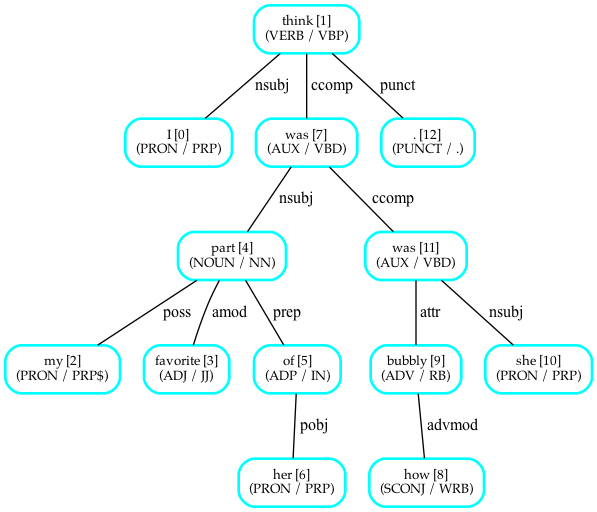

In [621]:
doc = nlp("I think my favorite part of her was how bubbly she was.")

png = visualise_spacy_tree.create_png(doc)
display(Image(png))

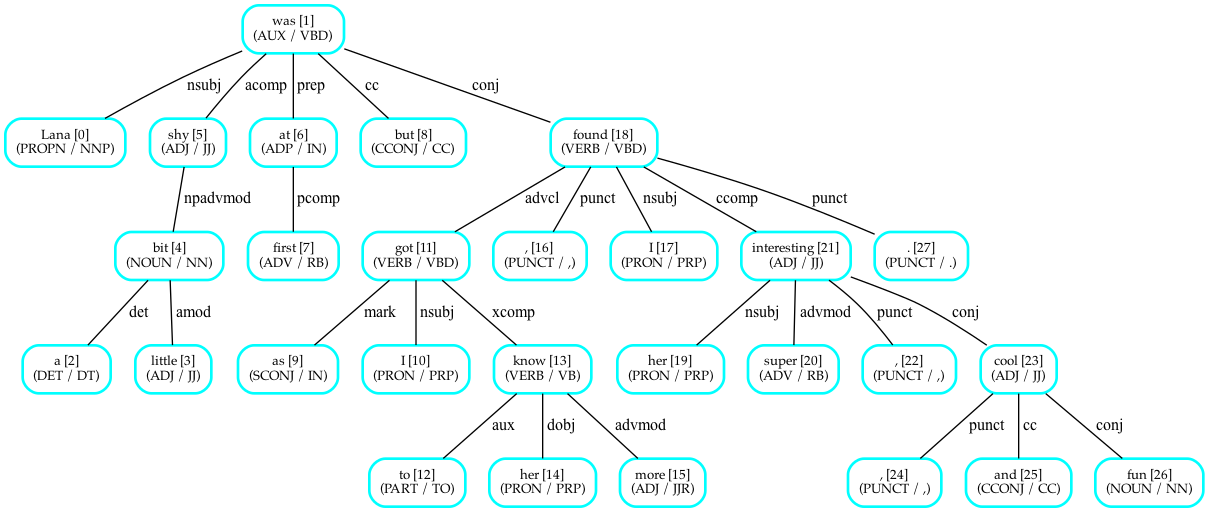

In [614]:
doc = nlp("Lana was a little bit shy at first but as I got to know her more, I found her super interesting, cool, and fun.")

png = visualise_spacy_tree.create_png(doc)
display(Image(png))

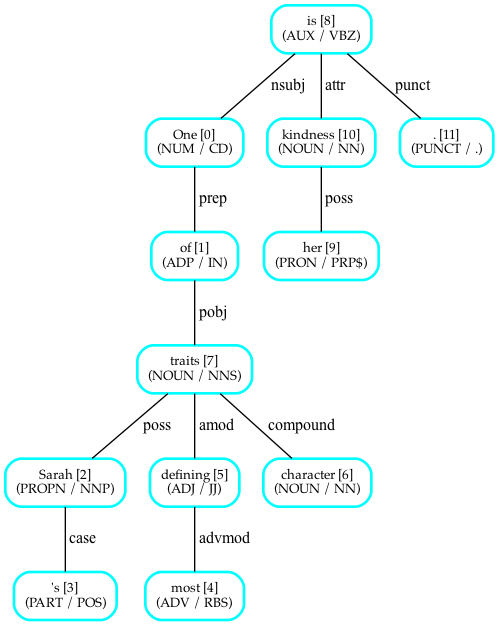

In [225]:
doc = nlp("One of Sarah's most defining character traits is her kindness.")

png = visualise_spacy_tree.create_png(doc)
display(Image(png))

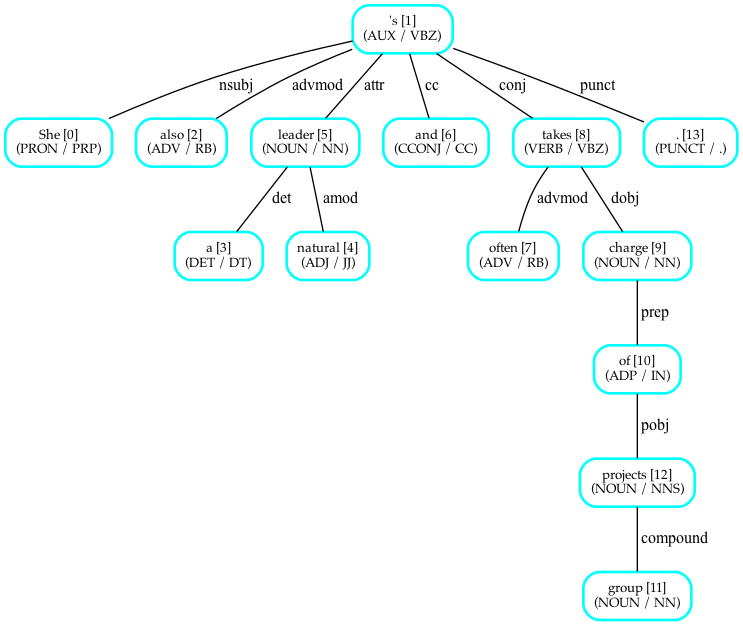

In [625]:
doc = nlp("She's also a natural leader and often takes charge of group projects.")

png = visualise_spacy_tree.create_png(doc)
display(Image(png))

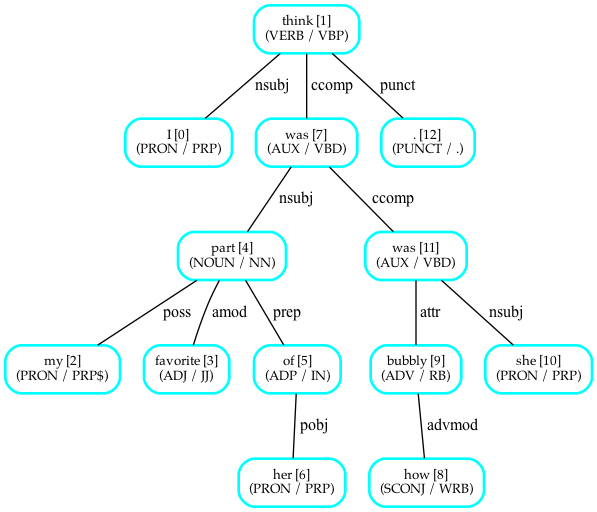

In [229]:
doc = nlp("I think my favorite part of her was how bubbly she was.")

png = visualise_spacy_tree.create_png(doc)
display(Image(png))